# PPO :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from task import Task, update_goal_curyctor
from alchemy.bot import Bot, BrainDescription
from alchemy.env import Env

from utils.crossexp import *

from utils.encoders import *
from utils.rnn import *
import model

from utils.replay import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
STATE_SIZE = 33 - 3
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#

N_REWARDS = 9
N_ACTORS = 1
MAX_STEPS = 60

### 3. Setup dummies ( unused feats in this environment )

In [3]:
def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)

### 4. Set model wrappers

In [4]:
def Actor(encoder):
    nes_layers = [encoder.out_size(), 400, 300, ACTION_SIZE]
    return lambda: model.ActorFactory(nes_layers, torch.tanh, action_size=ACTION_SIZE, ddpg=False)

def Critic(encoder):
    return lambda: model.Critic(N_ACTORS, N_REWARDS, encoder.out_size(), ACTION_SIZE, lambda x: x)

def callback(bot, task, test_scores, learn_scores, seeds, total):
    if test_scores is None:
        return
    print("\n\t==> test round with ", len(test_scores), test_scores, np.mean(learn_scores))
def dbgout(bot, score, actions):
    return


### 5. Setup && run agent/bot

In [5]:
PPO_LOOP = 3
bs = 4096

learning_delay = MAX_STEPS * PPO_LOOP

replay_ddpg = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=learning_delay * TOTAL_ENV * 2, select_count=40, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3)

encoder = Encoder()
brain_descriptions = [
        BrainDescription( # master :: PPO
            ddpg=False,
            count=TOTAL_ENV, n_groups=TOTAL_ENV, Actor=Actor(encoder), Critic=Critic(encoder),
            model_path="x_ppo_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ddpg, batch_size=bs,
            sync_delta=1, learning_delay=learning_delay, learning_repeat=TOTAL_ENV * 3,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=2e-1, dbgout=False,
            adv_on=True, adv_boost=False,                
            lr_actor=1e-4, lr_critic=5e-5, clip_norm=5.,
            tau_replay_counter=1, tau_base=1., tau_final=1.,
            replay_cleaning=False, prob_treshold=None),
    ]

bot = Bot(
# brain configs
        encoder,
        brain_descriptions,

        n_actors=2, n_critics=1,
        n_history=N_HISTORY, state_size=STATE_SIZE, action_size=ACTION_SIZE,
        n_step=N_STEP, floating_step=True, gamma=.99,        

# agent configs
        update_goal=update_goal_curyctor(N_STEP),
        her_max_ratio=1,
        gae=True, gae_tau=.95,
        freeze_delta=3, freeze_count=3,
        )

task = Task()

env = Env(bot, task,
        total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
        n_step=N_STEP, send_delta=N_STEP * 3,
        eval_limit=10, eval_ratio=.5, max_n_episode=MAX_STEPS, eval_delay=20,
        mcts_random_cap=1000, mcts_rounds=1)

scores = env.start(callback, dbgout)
losses = bot.brains[0].get_losses()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[   20>  1219:: 0] steps =   60, max_step =  61/ 60, reward=-0.037722 <action=[-1.06817072 -0.6932477  -0.93622243  0.06561265]>                                    
	==> test round with  1 [0.5824999869801126] -0.03772222222222222
[   40>  2439:: 0] steps =   60, max_step =  61/ 60, reward=0.009500 <action=[-0.17171599 -1.61763646 -0.50371293 -0.90964445]>                                     
	==> test round with  1 [1.2169999727979313] 0.009166666666666665
[   60>  3659:: 0] steps =   60, max_step =  61/ 60, reward=0.021278 <action=[-0.83473551 -1.57491715  0.99915968  1.07066698]>                                     
	==> test round with  1 [1.7764999602921225] 0.02133333333333334
[   80>  4879:: 0] steps =   60, max_step =  61/ 60, reward=0.034056 <action=[-0.40091661 -0.75123964 -0.79170532  1.24755956]>                                     
	==> test round with  1 [3.088999930955444] 0.03483333333333334
[  100>  6099:: 0] steps =   60, max_step =  61/ 60, reward=0.037389 <action=[-

In [6]:
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 4. Plot reward + loss

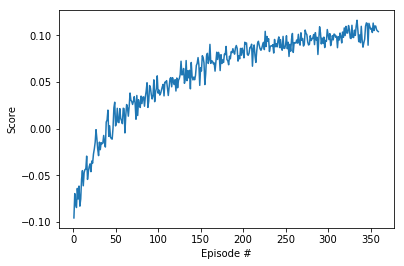

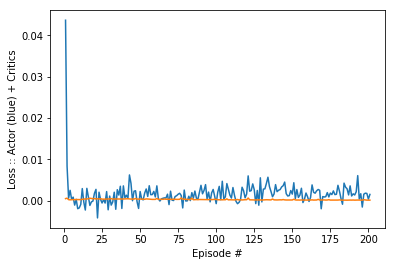

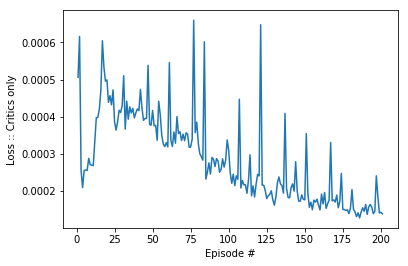

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses)
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses[:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [8]:
bot.sync_target(0, 0, [])
bot.sync_explorer(0, 0, [])

### 5. Test visuals - TARGET


 environment solved!  30.49109931847081
[30.341999321803417, 30.398999320529406, 31.71749929105864, 30.288499322999268, 30.691499313991535, 29.149999348446723, 30.053999328240764, 31.788499289471698, 29.160999348200836, 31.318999299965796]

 environment solved!  30.652599314861
[30.115999326854862, 32.41549927545711, 29.578499338868962, 30.015499329101328, 32.4734992741607, 31.341999299451704, 30.028999328799564, 31.392999298311757, 29.176499347854463, 29.986499329749513]

 environment solved!  30.7418493128661
[31.753499290253906, 31.10449930476023, 29.778499334398717, 29.058999350480736, 28.658499359432632, 29.903999331593507, 32.44049927489826, 32.50399927347899, 30.70499931368976, 31.510999295674257]

 environment solved!  30.642349315090097
[32.12399928197259, 32.295499278139346, 30.857999310269896, 30.861999310180575, 30.11099932696667, 30.008999329246592, 30.945999308302966, 29.45999934151768, 29.288499345351063, 30.469499318953634]

 environment solved!  30.542449317323037
[30

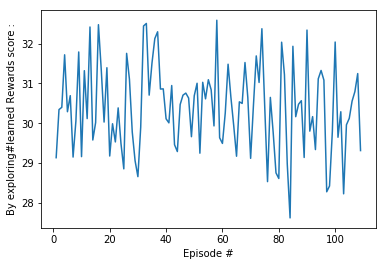

In [9]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER


 environment solved!  30.95309930814428
[30.51649931790307, 31.74999929033215, 31.121499304380254, 32.88799926489589, 30.17849932545798, 29.889999331906434, 29.286999345384572, 30.742499312851542, 30.847499310504638, 32.30949927782635]

 environment solved!  30.54619931723922
[31.403499298077108, 29.883499332051716, 32.42449927525598, 31.40249929809944, 28.99749935185532, 31.200499302614443, 30.482499318663066, 30.210499324742678, 30.16049932586031, 29.296499345172172]

 environment solved!  30.785549311889326
[30.58649931633847, 30.010999329201887, 30.79699931163339, 30.258999323658625, 31.520499295461935, 31.05349930590016, 31.711999291181556, 30.501499318238256, 31.10349930478258, 30.310999322496397]

 environment solved!  30.601549316002057
[31.429499297495965, 30.90799930915239, 30.439499319624225, 30.50799931809303, 29.99599932953717, 30.272499323356975, 31.23199930191042, 30.064499328006, 29.833999333158104, 31.331499299686314]

 environment solved!  30.804099311474733
[30.4384

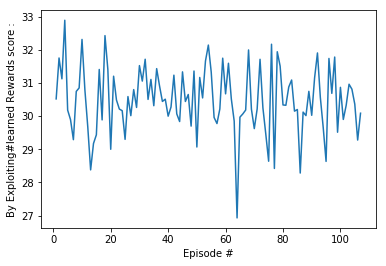

In [10]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[0].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 